# Overlapping densities (‘joy plot’) --verbose

[Seaborn](https://seaborn.pydata.org/) website provides [an example for making overlapping densities](https://seaborn.pydata.org/examples/kde_joyplot.html), aka [the trendy *joyplot*](https://twitter.com/search?q=%23joyplot), I believe by [Michael Waskom](http://www.cns.nyu.edu/~mwaskom/) ([@michaelwaskom](https://twitter.com/michaelwaskom)). But it is just an example program with a couple of trivial lines of descriptive, (c.f. motivating) code commentary, which does not qualify as a tutorial in my books. I would not have figured it out on my own, though, so a bit of a struggle with the example was very beneficial to me.

I personally struggle with example code listings, and benefit from some conceptual guidance and context. I wanted to learn to do joyplots and struggled with the example for a day, so thought I'd better re-write it more verbosely for myself to better understand how it works, and perhaps for others to enjoy too :)

# The original example

The [original example](https://seaborn.pydata.org/examples/kde_joyplot.html) is as follows:

![](https://seaborn.pydata.org/_images/kde_joyplot.png)

```
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
```

# --verbose

Let's¹ walk through the above example and try to understand what is happening, and how seaborn interacts with the data to produce a visualization.

¹ by "let's" I mean "Let me, and you too if you feel like it"

## Imports and setup

First, the original example imports relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We are working in a Jupyter Notebook here, so we want to either give the Jupyter Notebook magic for matplotlib to plot inline, or alternatively we could use seaborn specific `seaborn.set_context("notebook")`. Let's go for the most generic way to do it and set the for matplotlib.

In [2]:
%matplotlib inline

Next, one of [the seaborn styles](https://seaborn.pydata.org/tutorial/aesthetics.html#seaborn-figure-styles) is selected, and the field color `axes.facecolor` is overridden to be white, with zero opacity by providing a dict for `rc`.

In [3]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

## Constructing data for the example

It is crucial to understand what is happenin in the data creation to see how the eventual joyplot is created. The data is stored a `pandas.DataFrame` in the so-called [narrow shape](https://en.wikipedia.org/wiki/Wide_and_narrow_data), popular in e.g. [tidyverse](https://tidyverse.org) and described in Hadley Wickham's paper [*Tidy Data*](https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf) (Journal of Statistical Software, 2014. Vol 59, issue 10) but which I am not personally used to.

The narrow data shape looks like this:

|index $I$|variable $A$|value $V$|
|---------|------------|---------|
|1        | $a_1$      | $v_1$   |
|2        | $a_2$      | $v_2$   |
|3        | $a_3$      | $v_3$   |
|4        | $a_1$      | $v_4$   |
|5        | $a_2$      | $v_5$   |
|6        | $a_3$      | $v_6$   |
|7        | $a_1$      | $v_7$   |
|⋮        |⋮           |⋮         |
|$n$      | $a_3$      | $v_n$   |

With index $I$ (here a natural number $\mathbb{N}$), variables $A = (a_1, a_2, a_3)$, and values $V = v_1, v_2, \dots v_n$. Note how the tuple $V$ recycles.

Compare this with the *wide shape* of data:

|index $I$|variable $a_1$|variable $a_2$|variable $a_3$|
|---------|--------------|--------------|--------------|
|1        |$v_1$         |$v_2$         |$v_3$         |
|2        |$v_4$         |$v_5$         |$v_6$         |
|3        |$v_7$         |$\dots$       |$\dots$       |
|⋮        |⋮             |⋮              |⋮             |
|$n$      |$v^{a_1}_n$   |$v^{a_2}_n$   |$v^{a_3}_n$   |

In [4]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

Above, `np.random.RandomState` is a random number generator, which is given seed *1979*. Then 500 normally (Gaussian) distributed $\phi = \mathcal{N}(\mu, \sigma^2)$, with $\mu=0$ and $\sigma=1$, samples are drawn from it with `randn()`.

Next, `numpy.tile` is used create to ten variable A...J, fifty times, as required by the narrow data shape above. This is conceptually the same as

    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] * 50

in plain Python, as we can see:

In [5]:
g[:15]

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'A', 'B', 'C',
       'D', 'E'],
      dtype='<U1')

Next the `pandas.DataFrame` is constructed from a dict, with the variable column titled *g* and populated from the variable `g`, and the data column titled *x*, populated from `x`.

In [6]:
df.head(11)

,g,x
0,A,64.038123
1,B,66.147050
2,C,66.370011
3,D,68.791019
4,E,70.583534
5,F,69.135114
6,G,72.390092
7,H,73.822191
8,I,73.868785
9,J,72.938377


Finally a `m` is defined by running `ord` function over the dataframe variable column `g`, and then added to the values of x. The `ord` function returns the Unicode point of it's argument, with 'A' = 65, 'B' = 66 etc. This purpose of this here is to create the cascade of values visible in the example visualization, and create interesting structure in the data to look at. For each of the normally distributed $\phi = \mathcal{N}(\mu, \sigma^2)$ random variables $A \dots I$, this will give us $\mu_{A} = 65$, $\mu_{B} = 66$, $\mu_{C} = 67$ ... $\mu_{J} = 74$, and $\sigma = 1$ for all of them.

There are 50 samples for each of A...I.

One could imagine a time series or something like that.

## Setting up the plot

First, a palette is defined, with ten distinct colors because we have 10 variables A...I in the data, with some rotation around the hue wheel. -0.25 gives us a deep blue. The lightest color in the ten-color palette is set to 0.7, *ie.* some distance apart from no color intensity, which would be white.

Second, with the palette created, a `seaborn.FacetGrid` object is instantiated, and bound to the dataframe `df`. The `row` argument points to the name of the variable column in our narrow form data. This gives us a `FacetGrid` with 10 axes (ie. subplots), because we have 10 different values in the `g` of `df`.

The same column `g` is also used for color, so that each stacked subgraph is of one colour from our palette. Additionally `size` is used to set the height of the axes in inches (argh Imperial units), and `aspect` it's visual aspect ratio.

Please note the confusing re-use of variable name `g` in the example; the same name is given to the variable name array and then to the column in `df`, and here it is re-defined as a pointer to the `FacetGrid` object.

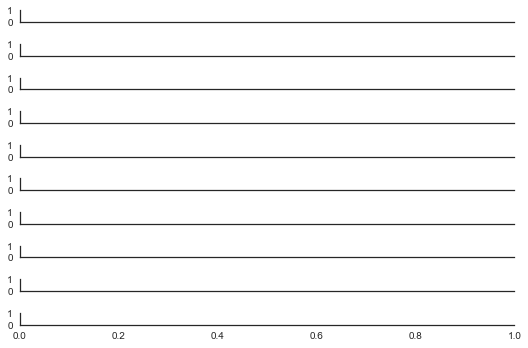

In [7]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

The `FacetGrid` called `g` has ten axes (=subplots), one per value in `df.g`, as we can see. At this stage of the (--verbose) tutorial nothing is plotted onto them.

## Plot the joyplot

Now, to actually draw the plot, the example maps a *kernel density estimate* plot across the ten subplots using `sns.kdeplot`, specifying the `x` column of the tied dataframe as the data. I struggled to understand how this works, until the required narrow data shape made sense to my brain.

Three plots are done for each subplot:

1. A coloured shade
1. A white outline
1. A straight horizontal line at the bottom

The palette does not need to be specified for the subplots, since the palette is already a property of the containing superobject `g`.

A custom function `label` places the variable name at the left edge of the plot, and is called for each subplot.

Then the subplots are moved upwards a quarter of a unit with `seaborn.FacetGrid.fig.subplots_adjust` to create the overlap characteristic of joyplots. Here the transparent background set with `sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})` at the very beginning of the program is important, since the horizontally lower subplot background would obstruct the plot above it (ie. *J* would partially obstruct *I*, *I* would partially obstruct *H* etc). You can set the last of the four 0's to a small value to see the partial overlap to learn about it.

Finally titles and yticks are cleared since they are non-relevant for joyplots, and `seaborn.despine` is used to remove parts of the default borders of the plot.

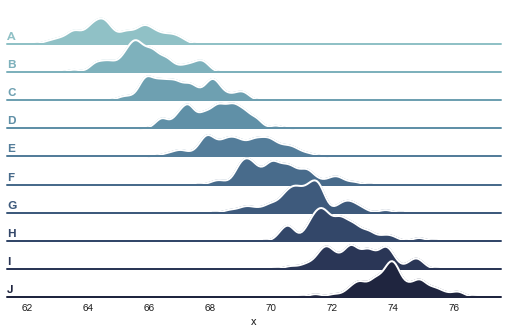

In [8]:
# repeated here to facilitate matplotlib/seaborn to keep it's plotting context in the cell
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)